# Using Mashine Learning to predict drug use from a dataset of OKCupid.

In [464]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 40)

data = pd.read_csv('profiles.csv')
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   essay0       54458 non-null  object 
 7   essay1       52374 non-null  object 
 8   essay2       50308 non-null  object 
 9   essay3       48470 non-null  object 
 10  essay4       49409 non-null  object 
 11  essay5       49096 non-null  object 
 12  essay6       46175 non-null  object 
 13  essay7       47495 non-null  object 
 14  essay8       40721 non-null  object 
 15  essay9       47343 non-null  object 
 16  ethnicity    54266 non-null  object 
 17  height       59943 non-null  float64
 18  income       59946 non-null  int64  
 19  job 

In [465]:
data.head(3)

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement<br />\nconversation<br />\ncreation<b...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available


## Scoping the dataset for usable columns for predicting **drug use**

In [466]:
#@title Code
#Print out information about a specific column in the dataframe
def colInfo(df, column):
  print("Column: "+column)
  print("Unique values:")
  print(df[column].unique())
  tNaN = df[column].isna().sum()
  total = len(df.values)
  ptNaN = (tNaN / total)*100
  print(f"Number of unique values: {len(df[column].unique())}")
  print(f"NaN entries: {tNaN} out of {total} or {ptNaN:.2f}%")
  print("\n")

  return None

_ = [colInfo(data, c) for c in ['diet', 'drinks', 'drugs', 'smokes', 'education', 'income']]

print("Number of profiles per income bracket and unreported")
print(data['income'].value_counts())

Column: diet
Unique values:
['strictly anything' 'mostly other' 'anything' 'vegetarian' nan
 'mostly anything' 'mostly vegetarian' 'strictly vegan'
 'strictly vegetarian' 'mostly vegan' 'strictly other' 'mostly halal'
 'other' 'vegan' 'mostly kosher' 'strictly halal' 'halal'
 'strictly kosher' 'kosher']
Number of unique values: 19
NaN entries: 24395 out of 59946 or 40.69%


Column: drinks
Unique values:
['socially' 'often' 'not at all' 'rarely' nan 'very often' 'desperately']
Number of unique values: 7
NaN entries: 2985 out of 59946 or 4.98%


Column: drugs
Unique values:
['never' 'sometimes' nan 'often']
Number of unique values: 4
NaN entries: 14080 out of 59946 or 23.49%


Column: smokes
Unique values:
['sometimes' 'no' nan 'when drinking' 'yes' 'trying to quit']
Number of unique values: 6
NaN entries: 5512 out of 59946 or 9.19%


Column: education
Unique values:
['working on college/university' 'working on space camp'
 'graduated from masters program' 'graduated from college/univers

socially    41780
Name: drinks, dtype: int64


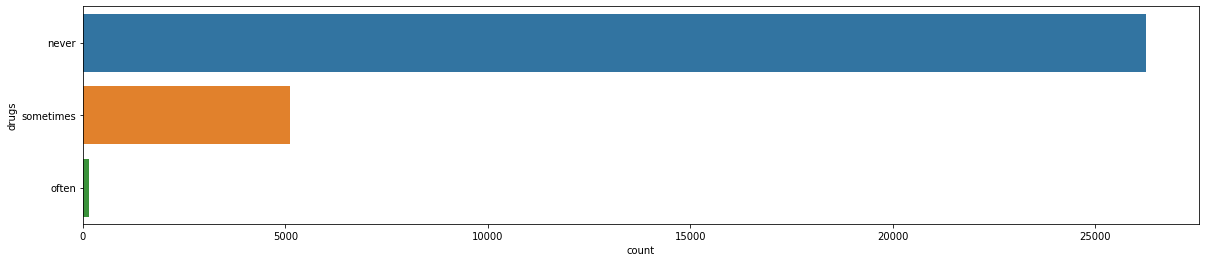

In [467]:
drinks_socially = data[data["drinks"] == 'socially']
print(drinks_socially['drinks'].value_counts())
fig_dims = (20, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="drugs", data=drinks_socially, ax=ax)
plt.show()

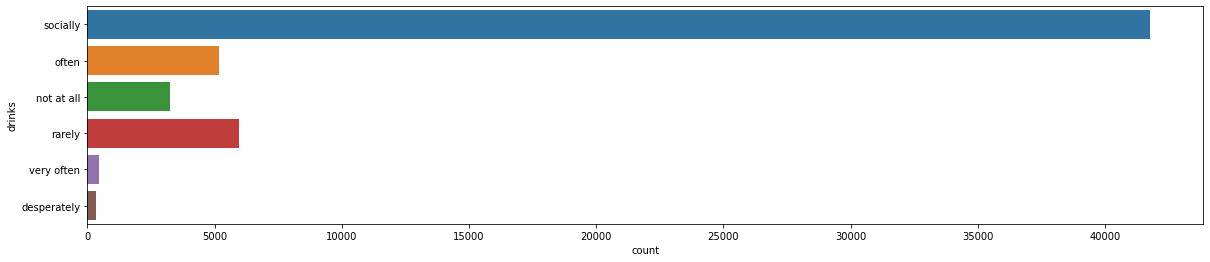

In [468]:
fig_dims = (20, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data=data, y='drinks',ax=ax)
plt.show()

very often     471
desperately    322
Name: drinks, dtype: int64


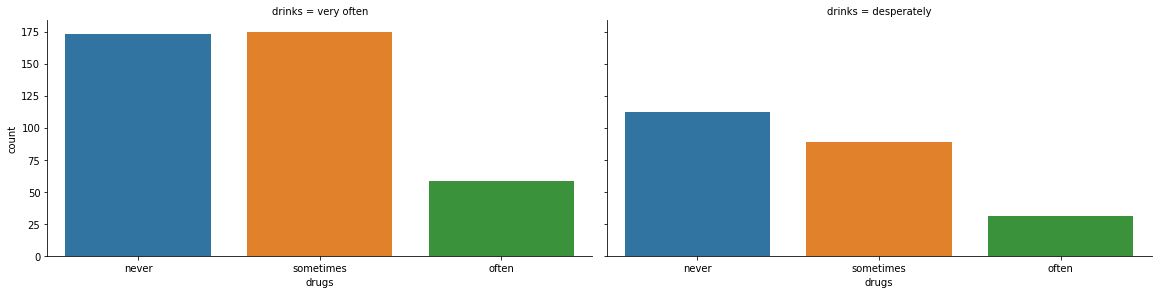

In [469]:
drinks_alot = data[(data["drinks"] != 'socially') & (data["drinks"] != 'rarely') & (data["drinks"] != 'not at all') & (data["drinks"] != 'often')]
print(drinks_alot['drinks'].value_counts())
g = sns.catplot(x="drugs", col="drinks",
                data=drinks_alot, kind="count",
                height=4, aspect=2)
plt.show()

rarely    5106
often     3636
Name: drinks, dtype: int64


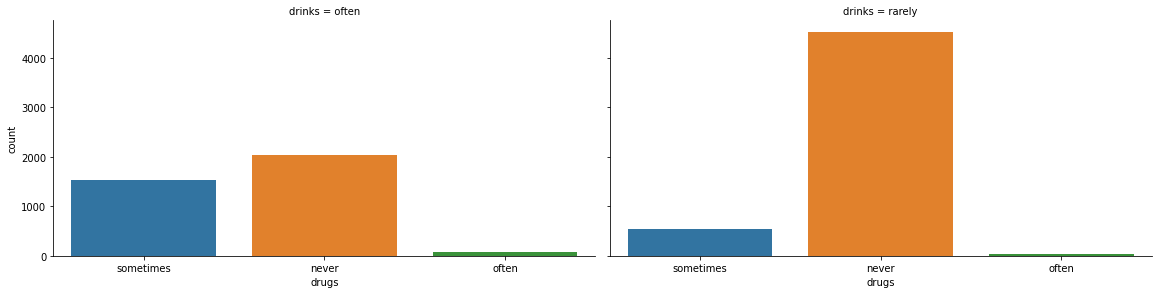

In [492]:
drinks_medium = data[(data["drinks"] != 'very often') & (data["drinks"] != 'not at all') & (data["drinks"] != 'desperately') & (data["drinks"] != 'socially')]
print(drinks_medium['drinks'].value_counts())
g = sns.catplot(x="drugs", col="drinks",
                data=drinks_medium, kind="count",
                height=4, aspect=2)
plt.show()

agnosticism     8812
other           7743
atheism         6985
christianity    5787
catholicism     4758
judaism         3098
buddhism        1948
hinduism         450
islam            139
Name: religion_new, dtype: int64


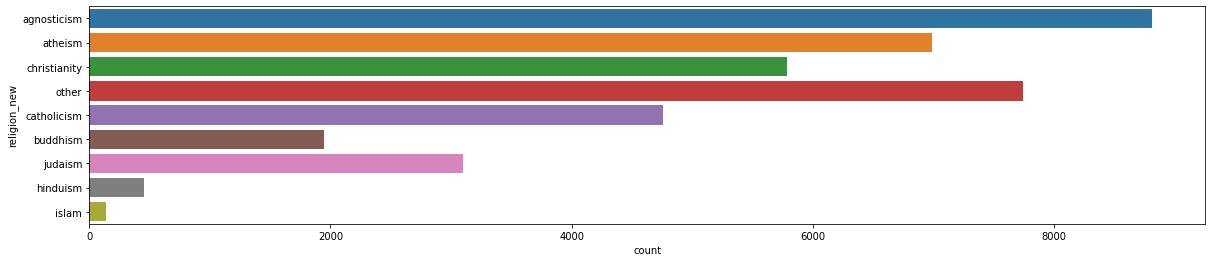

In [470]:
data['religion_new'] = data.religion.str.split().str.get(0)
print(data['religion_new'].value_counts())
fig_dims = (20, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data=data, y="religion_new",ax=ax)
plt.show()

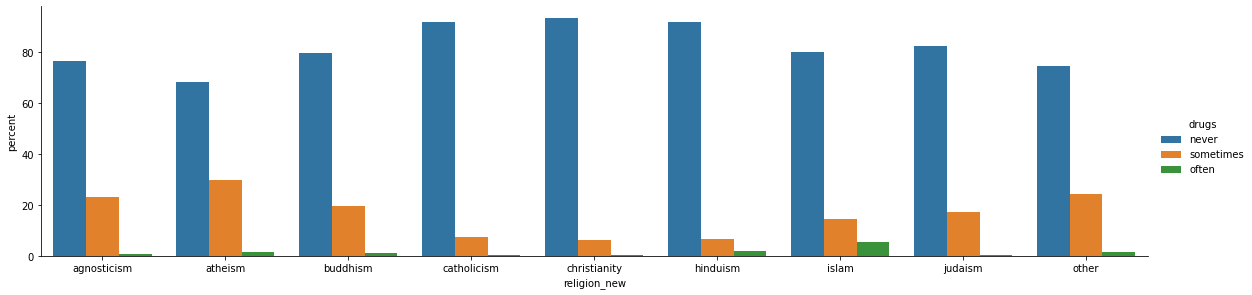

In [471]:
x,y = 'religion_new', 'drugs'
(data
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',height=4, aspect=20/5))
plt.show()

white               33472
asian                8205
hispanic / latin     4379
black                3071
other                1706
indian               1196
middle eastern        811
pacific islander      717
native american       709
Name: ethnicity_new, dtype: int64


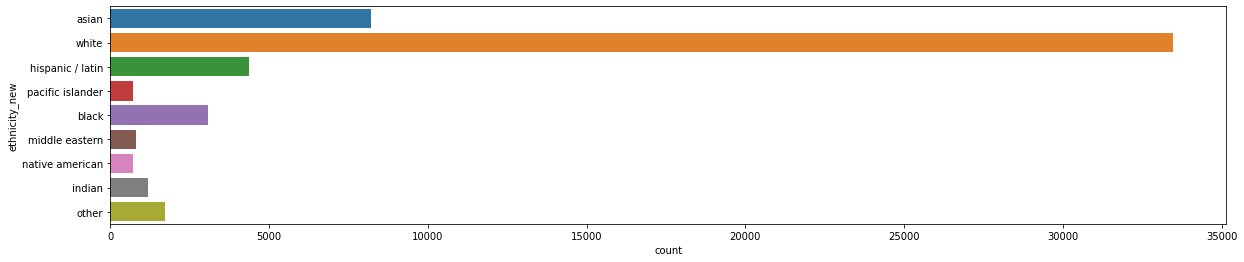

In [472]:
data['ethnicity_new'] = data.ethnicity.str.split(pat=',').str.get(0)
print(data['ethnicity_new'].value_counts())
fig_dims = (20, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data=data, y="ethnicity_new",ax=ax)
plt.show()

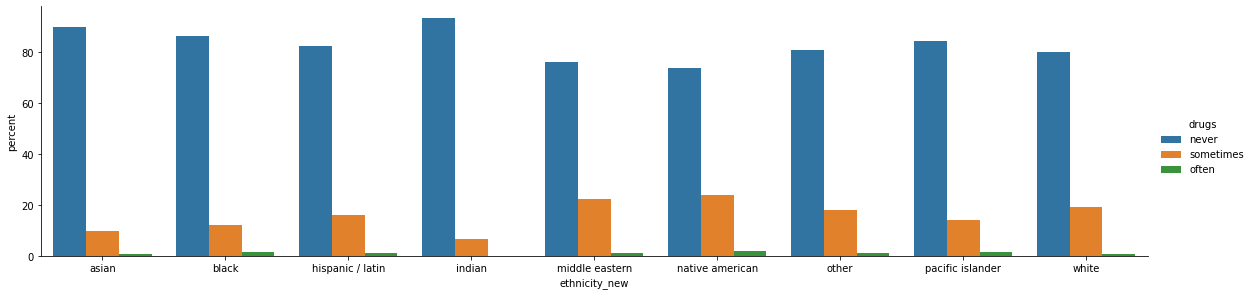

In [473]:
x,y = 'ethnicity_new', 'drugs'
(data
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',height=4, aspect=20/5))
plt.show()

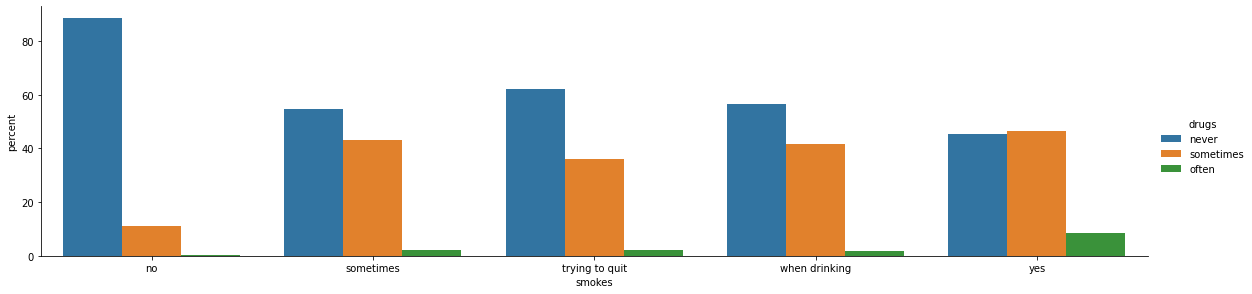

In [474]:
x,y = 'smokes', 'drugs'
(data
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',height=4, aspect=20/5))
plt.show()

#### Predicting drug use with numerical features and labels using Linear Regression

Converting continuous categories to numerical categories and drop rows with NAN.

In [475]:
data.dropna(subset=['drugs', 'smokes', 'drinks'], inplace=True)
print("Number of rows after dropna(): "+str(len(data)))

drinksList = ['socially', 'often', 'very often', 'desperately']
smokesList = ['sometimes', 'when drinking', 'yes', 'trying to quit']
drugsList = ['sometimes', 'often']
data['isDrugUser'] = data['drugs'].apply(lambda x: 1 if x in drugsList else 0)
data['isSmoker'] = data['drugs'].apply(lambda x: 1 if x in smokesList else 0)
data['isDrinker'] = data['drugs'].apply(lambda x: 1 if x in drinksList else 0)

Number of rows after dropna(): 42495


### Training and testing the model
- Select and Split Data
- Split out a subset of profiles to predict on before splitting the testing and training data
- training_data, test_data, training_labels, test_labels = train_test_split(features, drugUser, train_size=0.8, test_size=0.2)
- Scale the feature data so it has mean = 0 and standard deviation = 1
- Create and train the model
- Score the model on the train data
- Score the model on the test data
- Analyze the coefficients

In [476]:
features = data[['isSmoker', 'isDrinker']]
drugUser = data['isDrugUser']

trainTest_data, predict_data, trainTest_labels, predict_labels = train_test_split(features, drugUser, train_size=0.99, test_size=0.01)

training_data, test_data, training_labels, test_labels = train_test_split(trainTest_data, trainTest_labels, train_size=0.8, test_size=0.2)

sso = StandardScaler()

train_features = sso.fit_transform(training_data)
test_features = sso.transform(test_data)

model = LogisticRegression()
model.fit(training_data, training_labels)

trainScore = model.score(training_data, training_labels)

testScore = model.score(test_data, test_labels)

print(list(zip(['isSmoker','isDrinker'],model.coef_[0])))

[('isSmoker', 13.14763824578944), ('isDrinker', 10.350443970941447)]


<Figure size 432x288 with 0 Axes>

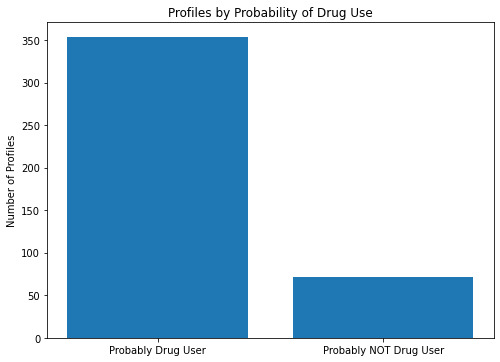

In [477]:
sample_profiles = sso.transform(predict_data)

model.predict(sample_profiles)
probabilities = model.predict_proba(sample_profiles)

countHighProbLikleyUser = 0
countHighProbLikleyNotUser = 0
threshold = .8
for prob in probabilities:
  if prob[0] >= threshold: countHighProbLikleyUser += 1
  if prob[1] >= threshold: countHighProbLikleyNotUser += 1

plt.clf()
fig, ax = plt.subplots(figsize=(8,6))
ax = plt.bar(x=['Probably Drug User', 'Probably NOT Drug User'], height=[countHighProbLikleyUser, countHighProbLikleyNotUser])
plt.ylabel("Number of Profiles")
plt.gcf().subplots_adjust(bottom=0.15)
plt.title("Profiles by Probability of Drug Use")

fig = plt.gcf()
plt.draw()
fig.savefig('users_vs_not_users.png', dpi=100, format='png')
plt.show()

### Predicting drug use with categorical features and labels

Selecting the label and the features with the (in my opinion) highest probability for prediction of drug use and dropping all rows with NAN.

In [478]:
cols = ['body_type', 'diet', 'orientation', 'pets', 'religion_new','ethnicity_new','smokes','offspring','sex','drugs']
df = data[cols].dropna()
df.shape

(8235, 10)

Convert categorical variable into dummy/indicator variables.

In [479]:
for col in cols[:-1]:
    df = pd.get_dummies(df, columns=[col], prefix = [col])

df.head(3)

,drugs,body_type_a little extra,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,diet_anything,diet_kosher,diet_mostly anything,diet_mostly halal,diet_mostly kosher,diet_mostly other,diet_mostly vegan,diet_mostly vegetarian,diet_other,diet_strictly anything,diet_strictly halal,diet_strictly kosher,diet_strictly other,diet_strictly vegan,diet_strictly vegetarian,diet_vegan,diet_vegetarian,orientation_bisexual,orientation_gay,orientation_straight,pets_dislikes cats,pets_dislikes dogs,pets_dislikes dogs and dislikes cats,pets_dislikes dogs and has cats,pets_dislikes dogs and likes cats,pets_has cats,pets_has dogs,pets_has dogs and dislikes cats,pets_has dogs and has cats,pets_has dogs and likes cats,pets_likes cats,pets_likes dogs,pets_likes dogs and dislikes cats,pets_likes dogs and has cats,pets_likes dogs and likes cats,religion_new_agnosticism,religion_new_atheism,religion_new_buddhism,religion_new_catholicism,religion_new_christianity,religion_new_hinduism,religion_new_islam,religion_new_judaism,religion_new_other,ethnicity_new_asian,ethnicity_new_black,ethnicity_new_hispanic / latin,ethnicity_new_indian,ethnicity_new_middle eastern,ethnicity_new_native american,ethnicity_new_other,ethnicity_new_pacific islander,ethnicity_new_white,smokes_no,smokes_sometimes,smokes_trying to quit,smokes_when drinking,smokes_yes,offspring_doesn&rsquo;t have kids,"offspring_doesn&rsquo;t have kids, and doesn&rsquo;t want any","offspring_doesn&rsquo;t have kids, but might want them","offspring_doesn&rsquo;t have kids, but wants them",offspring_doesn&rsquo;t want kids,offspring_has a kid,"offspring_has a kid, and might want more","offspring_has a kid, and wants more","offspring_has a kid, but doesn&rsquo;t want more",offspring_has kids,"offspring_has kids, and might want more","offspring_has kids, and wants more","offspring_has kids, but doesn&rsquo;t want more",offspring_might want kids,offspring_wants kids,sex_f,sex_m
0,never,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,sometimes,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,never,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [480]:
df.drugs.value_counts()

never        6577
sometimes    1550
often         108
Name: drugs, dtype: int64

### Splitting the data and turning it in to 1-dimensional arrays
- Y is the label column, X are the features
- Set the validation chunk size

In [481]:
col_length = len(df.columns)

X = df.iloc[:, 1:col_length]
Y = df.iloc[:, 0:1]

val_size = 0.2

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=val_size, random_state = 0)

Y_train = Y_train.to_numpy().ravel()
Y_val = Y_val.to_numpy().ravel()

#### Evaluation Metrics

- **Accuracy:** is the correct values divided by total values
- **Precision:** is the True Positives divided by the sum of True Positives and False Negatives. So precision is the values of the true positives divided by the actual positive values.
- **Recall:** is the True Positives divided by the sum of True Positives and False Positives. So recall is the values of the true positives divided by the positive guesses.
- **F1-score:** is a blended score of precision and recall which balances both values.
- **Macro Avg:** is the unweighted mean value of precision and recall. 
- **Weighted Avg:** is the weighted mean value of precision and recall by the support values for each class.
- **Support:** is the number of observations in class to predict.

#### Logistic Regression

In [482]:
lr_model = LogisticRegression(multi_class="multinomial",dual=False,max_iter=1200000).fit(X_train, Y_train)
lr_predictions = lr_model.predict(X_train)

The final accuracy of the logistic regression model is 83% considering a random guess should result in being correct ~33% of the time (1/3).

In [483]:
print(classification_report(Y_train, lr_predictions))

              precision    recall  f1-score   support

       never       0.85      0.96      0.90      5267
       often       0.54      0.08      0.14        87
   sometimes       0.59      0.31      0.40      1234

    accuracy                           0.82      6588
   macro avg       0.66      0.45      0.48      6588
weighted avg       0.80      0.82      0.80      6588



#### K Nearest Neighbor

The next models is the `KNeighborsClassifier` which will take 20 of it's neighbors to predict the drug use.

In [484]:
knn_model = KNeighborsClassifier(n_neighbors = 5).fit(X_train, Y_train)
knn_predictions = knn_model.predict(X_train)
print(classification_report(Y_train, knn_predictions))

              precision    recall  f1-score   support

       never       0.85      0.98      0.91      5267
       often       0.31      0.05      0.08        87
   sometimes       0.74      0.30      0.43      1234

    accuracy                           0.84      6588
   macro avg       0.63      0.44      0.47      6588
weighted avg       0.82      0.84      0.81      6588



#### Decision Trees

Added max_depth parameter as to not overfit 

In [485]:
cart_model = DecisionTreeClassifier(max_depth=15).fit(X_train, Y_train) 
cart_predictions = cart_model.predict(X_train) 
print(classification_report(Y_train, cart_predictions))

              precision    recall  f1-score   support

       never       0.91      0.96      0.94      5267
       often       1.00      0.59      0.74        87
   sometimes       0.79      0.62      0.69      1234

    accuracy                           0.89      6588
   macro avg       0.90      0.72      0.79      6588
weighted avg       0.89      0.89      0.89      6588



#### Confusion Matrix for Decision Trees

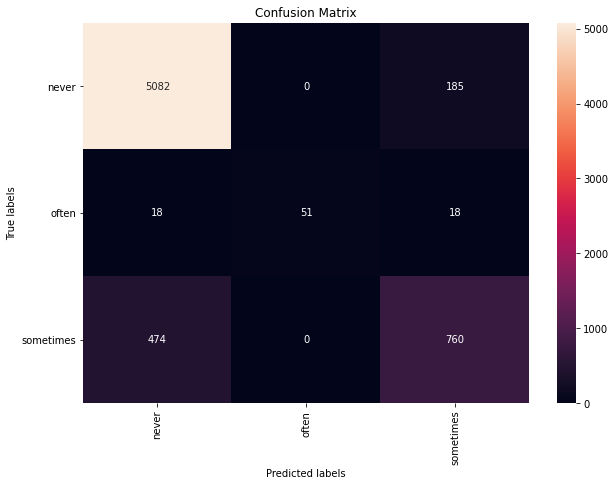

In [486]:
cart_cm = confusion_matrix(Y_train, cart_predictions)
cart_labels = cart_model.classes_


plt.figure(figsize=(10,7))

ax= plt.subplot()
sns.heatmap(cart_cm, annot=True, ax = ax,fmt="d");

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.yaxis.set_tick_params(rotation=360)
ax.xaxis.set_tick_params(rotation=90)

ax.xaxis.set_ticklabels(cart_labels); 
ax.yaxis.set_ticklabels(cart_labels);

In [487]:
cart_model.get_depth()

15

 Five fold cross validation is created with the same data. The results are much worse than the KNN and little bit worse than the Logistic Regression algorithms.

In [488]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
results = cross_val_score(cart_model, X_train, Y_train, cv=kfold, scoring='accuracy')

print(results)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.77389985 0.77010622 0.78603945 0.77220957 0.76917236]
Baseline: 77.43% (0.61%)


In [489]:
knn_predictionsVal = knn_model.predict(X_val) 
print(classification_report(Y_val, knn_predictionsVal))

              precision    recall  f1-score   support

       never       0.82      0.95      0.88      1310
       often       0.00      0.00      0.00        21
   sometimes       0.47      0.18      0.26       316

    accuracy                           0.79      1647
   macro avg       0.43      0.38      0.38      1647
weighted avg       0.74      0.79      0.75      1647



#### Confusion Matrix for K Nearest Neighbours

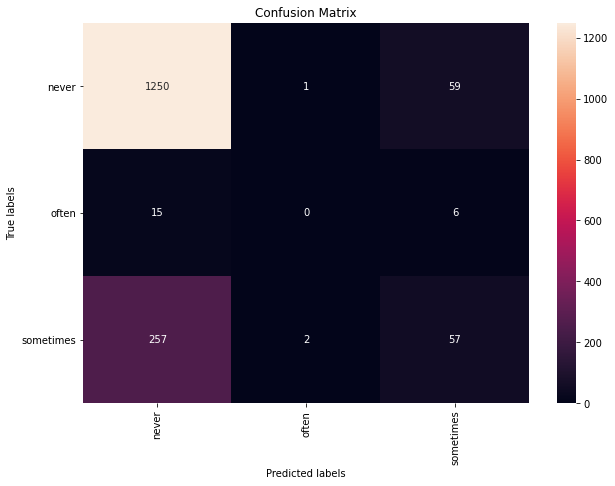

In [490]:
final_cm = confusion_matrix(Y_val, knn_predictionsVal)
knn_labels = knn_model.classes_

plt.figure(figsize=(10,7))

ax= plt.subplot()
sns.heatmap(final_cm, annot=True, ax = ax, fmt="d");

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.yaxis.set_tick_params(rotation=360)
ax.xaxis.set_tick_params(rotation=90)

ax.xaxis.set_ticklabels(knn_labels); 
ax.yaxis.set_ticklabels(knn_labels);